<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/master/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone https://github.com/soukhind2/vgg16obj


Cloning into 'vgg16obj'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 104 (delta 49), reused 51 (delta 22), pack-reused 0
Receiving objects: 100% (104/104), 843.32 KiB | 6.54 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [5]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class

In [6]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools





In [18]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data_6class/train/faces/Male',train_it)
train_it = convertimgs('/content/data_6class/train/faces/Female/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Manmade/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Natural/',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Powered',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Nonpowered',train_it)
train_it = np.array(train_it)

val_it = []
val_it = convertimgs('/content/data_6class/val/faces/Male/',val_it)
val_it = convertimgs('/content/data_6class/val/faces/Female/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Manmade/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Natural/',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Powered',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Nonpowered',val_it)
val_it = np.array(val_it)

test_it = []
test_it = convertimgs('/content/data_6class/test/faces/Male/',test_it)
test_it = convertimgs('/content/data_6class/test/faces/Female/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Manmade/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Natural/',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Powered',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Nonowered',test_it)
test_it = np.array(test_it)

print(train_it.shape,val_it.shape,test_it.shape)


(1554, 224, 224, 3) (150, 224, 224, 3) (162, 224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

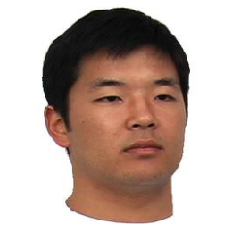

In [19]:
import matplotlib.pyplot as plt
plt.imshow(train_it[0])
plt.axis('off')

In [20]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])
#plot_model(model,show_shapes=True,expand_nested=True)

58892288/58889256 [==============================] - 1s 0us/step


In [21]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
#np.save('features_train' , features_train)
#np.save('features_val', features_val)
#np.save('features_test', features_test)

Train Time: 14.218675374984741
Val Time: 1.514655590057373
Test Time: 0.946021556854248


In [22]:
epochs = 30

#train_data = np.load('features_train.npy')
train_data = features_train
train_labels = to_categorical([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279,6)
train_labels1 = to_categorical([0] * 250 + [1]*250 + [0] * 250 + [1] * 250 + [0] * 275 + [1] * 279,2)
train_labels2 = to_categorical([0] * 250 + [0]*250 + [1] * 250 + [1] * 250 + [2] * 275 + [2] * 279,3)



#val_data = np.load('features_val.npy')
val_data = features_val
val_labels = to_categorical([0] * 25 + [1]*25 + [2] * 25 + [3] * 25 + [4] * 25 + [5] * 25,6)
val_labels1 = to_categorical([0] * 25 + [1]*25 + [0] * 25 + [1] * 25 + [0] * 25 + [1] * 25,2)
val_labels2 = to_categorical([0] * 25 + [0]*25 + [1] * 25 + [1] * 25 + [2] * 25 + [2] * 25,3)


#test_data = np.load('features_test.npy')
test_data = features_test
#test_labels = [0] * 50 + [1] * 50 + [2] * 50
#test_labels = [0] * 61 + [1] * 40 + [2] * 61
test_labels = to_categorical([0] * 31 + [1]*30 + [2] * 19 + [3] * 21 + [4] * 31 + [5] * 30,6)
test_labels1 = to_categorical([0] * 31 + [1]*30 + [0] * 19 + [1] * 21 + [0] * 31 + [1] * 30,2)
test_labels2 = to_categorical([0] * 31 + [0]*30 + [1] * 19 + [1] * 21 + [2] * 31 + [2] * 30,3)
#test_labels = to_categorical(test_labels, 3)


In [9]:
#@title Manual model generation
from tensorflow import keras
from tensorflow.keras import layers

input = keras.Input(shape= train_data.shape[1:])
x = layers.Flatten()(input)
x = layers.Dense(4096, activation="relu")(x)

#branch1
b1 = layers.Dense(1024, activation="relu")(x)
o1 = layers.Dense(2,activation="softmax")(b1)

#branch2
b2 = layers.Dense(1024, activation="relu")(x)
o2 = layers.Dense(3,activation="softmax")(b2)


#outputs = layers.Dense(6,activation="softmax")(x)
model1 = keras.Model(inputs=input, outputs=o1)
model2 = keras.Model(inputs=input, outputs=o2)



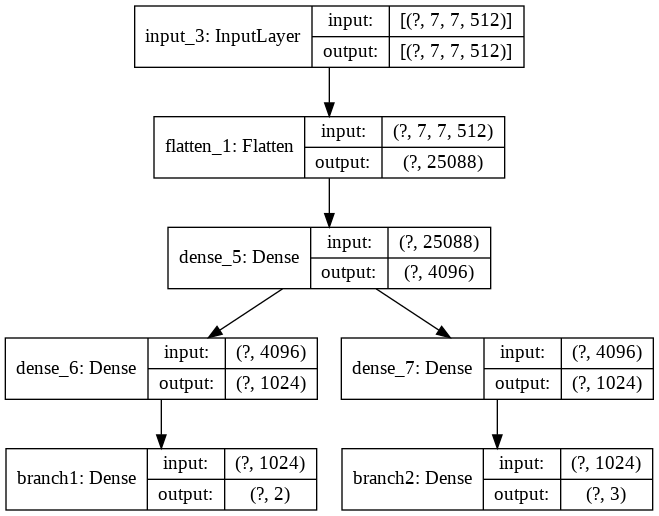

In [27]:
from vgg16obj.tools import objnet

model = objnet.modelarch().build_full_model([7,7,512],
                                            stem_len = [4096],
                                            b1_len = [1024],
                                            b2_len = [1024])
plot_model(model,show_shapes=True,expand_nested=True)

In [28]:
'''
model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(4096, activation='relu')) 
##model.add(Dropout(0.5)) 
model.add(Dense(4096, activation='relu')) 
model.add(Dense(6, activation='softmax'))
model.summary()
'''

losses = {'branch1': 'binary_crossentropy',
          'branch2': 'categorical_crossentropy'}

model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(x = train_data,  y = {'branch1':train_labels1,'branch2':train_labels2},
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, {'branch1':val_labels1,'branch2':val_labels2}),
          verbose = 1, callbacks = [es])

#model.save_weights('top_weights',overwrite = True)



Epoch 1/30
25/25 [==============================] - 1s 38ms/step - loss: 0.8960 - branch1_loss: 0.5537 - branch2_loss: 0.3423 - branch1_accuracy: 0.7117 - branch2_accuracy: 0.9221 - val_loss: 0.5613 - val_branch1_loss: 0.4853 - val_branch2_loss: 0.0760 - val_branch1_accuracy: 0.7600 - val_branch2_accuracy: 0.9867
Epoch 2/30
25/25 [==============================] - 1s 29ms/step - loss: 0.3934 - branch1_loss: 0.3564 - branch2_loss: 0.0370 - branch1_accuracy: 0.8443 - branch2_accuracy: 0.9981 - val_loss: 0.4401 - val_branch1_loss: 0.3983 - val_branch2_loss: 0.0418 - val_branch1_accuracy: 0.8333 - val_branch2_accuracy: 0.9933
Epoch 3/30
25/25 [==============================] - 1s 29ms/step - loss: 0.2812 - branch1_loss: 0.2629 - branch2_loss: 0.0183 - branch1_accuracy: 0.9086 - branch2_accuracy: 0.9994 - val_loss: 0.4116 - val_branch1_loss: 0.3782 - val_branch2_loss: 0.0334 - val_branch1_accuracy: 0.8267 - val_branch2_accuracy: 0.9933
Epoch 4/30
25/25 [==============================] - 1s 

In [31]:
out = model.evaluate(test_data, {'branch1':test_labels1,'branch2':test_labels2})
print(out)

pred = model.predict(test_data)

#print('rounded test labels',pred)

6/6 [==============================] - 0s 6ms/step - loss: 0.4541 - branch1_loss: 0.4487 - branch2_loss: 0.0054 - branch1_accuracy: 0.8210 - branch2_accuracy: 1.0000
[0.4540719985961914, 0.4486500322818756, 0.005421983078122139, 0.8209876418113708, 1.0]


In [ ]:
#classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
#metric = metrics.classification_report(test_labels,pred,target_names = classes)
print(metric)


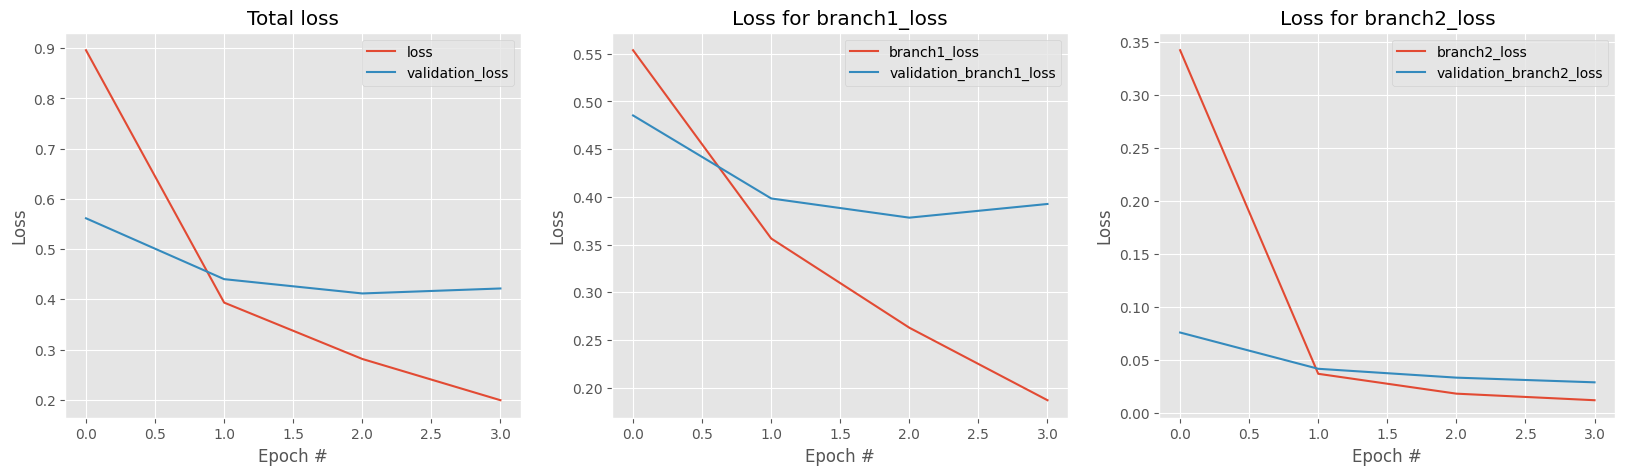

In [32]:

lossNames = ["loss", "branch1_loss", "branch2_loss"]
plt.style.use("ggplot")
e = len(history.history['loss'])
(fig, ax) = plt.subplots(1, 3, figsize=(20, 5))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, e), history.history[l], label=l)
	ax[i].plot(np.arange(0, e), history.history["val_" + l],
		label="validation_" + l)
	ax[i].legend()


Normalized confusion matrix


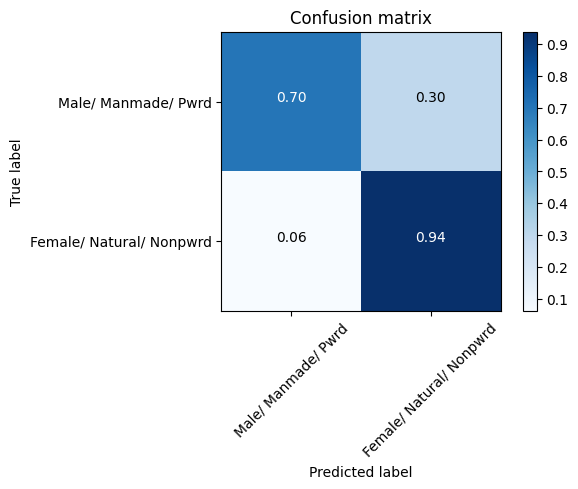

In [30]:
#classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
classes = ['Male/ Manmade/ Pwrd','Female/ Natural/ Nonpwrd']
#classes = ['Face', 'Scene','Tool']
plt.style.use('default')

from vgg16obj.tools import plot_tools as pt
#pt.plot_metrics(history)


categorical_test_labels = pd.DataFrame(test_labels1).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred[0]).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = True)

In [ ]:
plot_model(model,show_shapes=True,expand_nested=True)